In [353]:
import networkx as nx
import matplotlib.pyplot as plt

In [354]:
import matplotlib.cm as cm  # Para usar una paleta de colores continua
from networkx.drawing.nx_agraph import graphviz_layout

def mostrar_grafo(G):
    plt.figure(figsize=(10,10))
    #pos = nx.spring_layout(G,k=1)
    #pos=nx.circular_layout(G)
    #pos=nx.shell_layout(G)
    pos=nx.random_layout(G)
    #pos = graphviz_layout(G, prog='dot')
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    
    
    # Obtener todos los valores de profundidad para ajustar el rango de colores
    profundidades = [G.nodes[node].get('profundidad', 0) for node in G.nodes]
    
    # Normalizar las profundidades para asignar colores continuos en una escala
    min_prof, max_prof = min(profundidades), max(profundidades)
    colors = [
        cm.viridis((prof - min_prof) / (max_prof - min_prof)) if max_prof > min_prof else cm.viridis(0.5)
        for prof in profundidades
    ]
    
    nx.draw(G,with_labels=False, node_color=colors, edge_color="gray", node_size=2000, font_size=10)
    # Prepara las etiquetas con atributos de cada nodo
    labels = {node: f"n:{node}\np:{G.nodes[node].get('profundidad', '')}" for node in G.nodes}
    
    # Dibuja las etiquetas de los nodos con sus atributos
    nx.draw_networkx_labels(G, labels, font_size=15, font_color="white")
    
    plt.margins(0.2)
    plt.show()

In [355]:
def describir_arbol(G):
    def describir_arbol_aux(nodo, G, profundidad):
        hijos = list(G.successors(nodo))
        resultado = "\t"*profundidad+f"Nodo: {nodo} | Profundidad: {G.nodes[nodo]['profundidad']}\n"
        if hijos != []:
            for hijo in hijos:
                resultado+=describir_arbol_aux(hijo,G,profundidad+1)
        return resultado
    nodes = list(G.nodes)
    string = describir_arbol_aux(nodes[0],G,0)
    print(string)

In [356]:
def hojas_preorden(G):
    hojas = {n for n, out_d in G.out_degree() if out_d == 0}
    recorrido_preorden = list(nx.dfs_preorder_nodes(G, source=1))
    lista_hojas = [nodo for nodo in recorrido_preorden if nodo in hojas]
    return lista_hojas

#### Creación del grafo simultánea.
Al crear el grafo simultáneamente, se aprovecha la estructura del árbol para formarlo. Cada vez que el algoritmo de space partitioning selecciona un nodo y crea sus hijos en el árbol, se crean en esa misma iteración del bucle las conexiones de los nuevos nodos entre sí. Una vez esas conexiones están creadas, se conectan los nuevos nodos con las capas superiores:
> Si su padre tuvo hermanos('contiguos' != []), se conectan los hijos adyacentes a los hermanos con estos últimos, añadiendo también esta conexión al parámetro contiguos para conexiones más complejas en las que la diferencia de profundidad sea mayor que 1.
Problema: No se puede limitar la conexión de los hijos de diferentes nodos en el mismo nivel. Al ser "heredado" el atributo 'contiguos', se hereda la conexión con ambos nodos de abajo, cuando los nodos hijo estarían conectados con un solo nodo cada uno.

In [357]:
import random

def formar_particion_estado_4(n):
    lista_hojas = []
        
    A = nx.DiGraph()
    A.add_node(1, profundidad=0)
    A.graph['altura'] = 0
    
    lista_hojas.append(1)
    nodos=1
    
    for i in range(1,n+1):
        esValido = True
        selec = random.choice(lista_hojas)
        profundidad = nx.shortest_path_length(A, source=1,target=selec)+1
        count = 0
        
        while profundidad == 5:
            selec = random.choice(lista_hojas)
            profundidad = nx.shortest_path_length(A, source=1,target=selec)+1
            count += 1
            if count > 256:
                esValido = False
                print(esValido)
                break
        if esValido: 
            if profundidad > A.graph['altura']:
                A.graph['altura'] = profundidad
            
            A.add_node(nodos+1,profundidad=profundidad)
            A.add_node(nodos+2,profundidad=profundidad)
            A.add_node(nodos+3,profundidad=profundidad)
            A.add_node(nodos+4,profundidad=profundidad)
            A.add_edges_from([(selec,nodos+1),(selec,nodos+2),(selec,nodos+3),(selec,nodos+4)])
            #print("Añadidos hijos "+str(nodos+1)+" y "+str(nodos+2))
            lista_hojas.append(nodos+1)
            lista_hojas.append(nodos+2)
            lista_hojas.append(nodos+3)
            lista_hojas.append(nodos+4)
            lista_hojas.remove(selec)
            
            nodos+=4
    return A

In [358]:
import matplotlib.patches as patches
import copy

class Cuadrado():
    def __init__(self, G, nodo=1, centro=(5, 5), tamaño=10):
        self.G=G
        self.S = nx.Graph()
        self.nodo = nodo
        self.centro = centro
        self.tamaño = tamaño
        self.tipo = 'pared'
        

        self.profundidad = self.G.graph['altura']
        
        # limites = [arriba,derecha,abajo,izquierda]
        offset = self.tamaño/2
        self.limites = [
            self.centro[1]+offset,
            self.centro[0]+offset,
            self.centro[1]-offset,
            self.centro[0]-offset
        ]

        self.cuadrantes = []
        self.hijos = []

        hijos = list(self.G.successors(nodo))

        if hijos:
            # Se divide por cuatro porque tiene la mitad de tamaño, y después se divide a la mitad otra vez para determinar el centro.
            mitad_tamaño = self.tamaño / 2
            centro_cuadrante = mitad_tamaño / 2
            offsets = [
                (-centro_cuadrante, centro_cuadrante),  # Cuadrante arriba izquierda
                (centro_cuadrante, centro_cuadrante),  # Cuadrante arriba derecha
                (-centro_cuadrante, -centro_cuadrante),  # Cuadrante abajo izquierda
                (centro_cuadrante, -centro_cuadrante)  # Cuadrante abajo derecha
            ]

            for hijo, offset in zip(hijos, offsets):
                nuevo_centro = (self.centro[0] + offset[0], self.centro[1] + offset[1])
                self.cuadrantes.append(Cuadrado(self.G, hijo, nuevo_centro, mitad_tamaño))
            
    def formar_grafo(self):
        lista_hojas = self.hojas_preorden()
        for i in lista_hojas:
            #print(lista_hojas)
            yo = self.encontrar_cuadrante(i)
            #print(f"Hoja {yo.nodo}")
            if yo.nodo not in self.S.nodes:
                self.S.add_node(yo.nodo)
                self.S.nodes[yo.nodo]['arriba'] = []
                self.S.nodes[yo.nodo]['derecha'] = []
                self.S.nodes[yo.nodo]['izquierda'] = []
                self.S.nodes[yo.nodo]['abajo'] = []
                self.S.nodes[yo.nodo]['tamaño'] = 4 - self.G.nodes[yo.nodo]['profundidad']
                
            for j in lista_hojas:
                tu = self.encontrar_cuadrante(j)
                #print(f"\tHoja {tu.nodo}")
                
                if tu.nodo not in self.S.nodes:
                    self.S.add_node(tu.nodo)
                    self.S.nodes[tu.nodo]['arriba'] = []
                    self.S.nodes[tu.nodo]['derecha'] = []
                    self.S.nodes[tu.nodo]['izquierda'] = []
                    self.S.nodes[tu.nodo]['abajo'] = []
                    self.S.nodes[tu.nodo]['tamaño'] = 4 - self.G.nodes[tu.nodo]['profundidad']
                
                if i == j:
                    #print("Comparación de iguales")
                    continue
                
                # Conexión hacia arriba
                if yo.limites[0] == tu.limites[2]:
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['arriba']:
                            self.S.nodes[yo.nodo]['arriba'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['abajo']:
                            self.S.nodes[tu.nodo]['abajo'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
                # Conexión hacia la derecha
                if yo.limites[1] == tu.limites[3]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['derecha']:
                            self.S.nodes[yo.nodo]['derecha'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['izquierda']:
                            self.S.nodes[tu.nodo]['izquierda'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia abajo
                if yo.limites[2] == tu.limites[0] :
                    #print("\tLimites superior e inferior coinciden.")
                    if yo.limites[1] >= tu.limites[1] and yo.limites[3] <= tu.limites[3]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['abajo']:
                            self.S.nodes[yo.nodo]['abajo'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['arriba']:
                            self.S.nodes[tu.nodo]['arriba'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                        
                # Conexión hacia la izquierda
                if yo.limites[3] == tu.limites[1]:
                    #print("\tLimites derecha e izquierda coinciden.")
                    if yo.limites[0] <= tu.limites[0] and yo.limites[2] >= tu.limites[2]:
                        self.S.add_edge(tu.nodo,yo.nodo)
                        if tu.nodo not in self.S.nodes[yo.nodo]['izquierda']:
                            self.S.nodes[yo.nodo]['izquierda'].append(tu.nodo)
                        if yo.nodo not in self.S.nodes[tu.nodo]['derecha']:
                            self.S.nodes[tu.nodo]['derecha'].append(yo.nodo)
                        #print(f"\tConecta con {tu.nodo}")
                
    def encontrar_cuadrante(self, id):
        """
        Busca el cuadrante que contiene el nodo con el ID especificado.
        Imprime un mensaje si no lo encuentra y detiene la búsqueda.
        """
        if self.nodo == id:
            #print(f"Nodo encontrado: {self.nodo}")
            return self
    
        for cuadrante in self.cuadrantes:
            resultado = cuadrante.encontrar_cuadrante(id)
            if resultado:
                return resultado
            
    def hojas_preorden(self):
        hojas = {n for n, out_d in self.G.out_degree() if out_d == 0}
        recorrido_preorden = list(nx.dfs_preorder_nodes(self.G, source=1))
        return [nodo for nodo in recorrido_preorden if nodo in hojas]
    
    def crear_mazmorra_clasica(self):
        lista_hojas = self.hojas_preorden()
        nodos = self.S.nodes   
        selec = random.choice(lista_hojas)
        tamaño = nodos[selec]['tamaño']
        
        if tamaño == 0:
            pass
        elif tamaño == 1:
            pass
        elif tamaño == 2:
            direcciones = []
            # Para cada dirección posible desde el nodo seleccionado...
            for attr in nodos[selec]:
                if attr != 'tamaño':
                    posible = 0
                    # Si en esa dirección el cuadrante contiguo tiene exactamente un tamaño menos...
                    for nodo in nodos[selec][attr]:
                        if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                            posible+=1
                    # Y hay dos de estos cuadrantes contiguos, es posible expandir en esa dirección
                    if posible == 2:
                        direcciones.append(attr)
            print(f"Posibles: {direcciones}")
            if direcciones:
                expandir = random.choice(direcciones)
                cuadrante = self.encontrar_cuadrante(selec)
                cuadrante.tipo='suelo'
                for nodo in nodos[selec][expandir]:
                    cuadrante = self.encontrar_cuadrante(nodo)
                    cuadrante.tipo='suelo'
                
        elif tamaño == 3:
            cuadrante = self.encontrar_cuadrante(selec)
            cuadrante.tipo='suelo'
    
    
    def crear_mazmorra_dikjstra(self, n=5):
        pintados = []
        lista_hojas = self.hojas_preorden()
        print(f"Lista de hojas: {lista_hojas}")
        
        inicio = random.choice(lista_hojas)
        fin = random.choice(lista_hojas)
        while inicio == fin:
            fin = random.choice(lista_hojas)
        
        print(f"Camino de {inicio} a {fin}:")
        camino = nx.shortest_path(self.S, source = inicio, target = fin)
        print(camino)
        
        for nodo in camino:
            pintados.append(nodo)
            print(f"\tNodo: {nodo} pintado")
            cuadrante = self.encontrar_cuadrante(nodo)
            cuadrante.tipo='suelo'
            
        for i in range(n-1):
            inicio = random.choice(lista_hojas)
            fin = random.choice(pintados)
            while inicio == fin:
                fin = random.choice(pintados)
            
            print(f"Camino de {inicio} a {fin}:")
            camino = nx.shortest_path(self.S, source = inicio, target = fin)
            print(camino)
            
            for nodo in camino:
                print(f"\tNodo: {nodo} pintado")
                cuadrante = self.encontrar_cuadrante(nodo)
                cuadrante.tipo='suelo'
            
    def __str__(self):
        """
        Representación en texto del cuadrado.
        """
        return f"Cuadrado(nodo={self.nodo},tipo={self.tipo},límites={self.limites})"

    def imprimir_estructura(self, nivel=0):
        """
        Imprime la estructura jerárquica del cuadrado.
        """
        print(" " * nivel * 4 + str(self))
        for cuadrante in self.cuadrantes:
            cuadrante.imprimir_estructura(nivel + 1)
    def dibujar(self):       
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Configuración del fondo transparente
        fig.patch.set_alpha(0)  # Fondo de la figura transparente
        ax.patch.set_alpha(0)   # Fondo del eje transparente
        
        self.dibujar_aux(ax)
        
        """
        try:
            # Leer el valor del contador desde el archivo
            with open('Cuadrados/contador', 'r') as f:
                contador = int(f.read().strip())
        except FileNotFoundError:
            # Si el archivo no existe, inicializar el contador en 0
            contador = 0
        except ValueError:
            # Si el archivo contiene datos no válidos, también inicializar en 0
            contador = 0
        contador+=1
        fig.savefig('Cuadrados/cuadrado'+str(contador)+'.png', transparent=True, bbox_inches='tight')
        
        with open('Cuadrados/contador', 'w') as f:
            f.write(str(contador))
        """
         
    def dibujar_aux(self, ax):
        # Dibuja el cuadrado actual
        x, y = self.centro
        tamaño = self.tamaño
        if self.tipo == 'pared':
            rect = patches.Rectangle(
                (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                linewidth=1, edgecolor='grey', facecolor='black'
            )
            ax.add_patch(rect)
        elif self.tipo == 'suelo':
            rect = patches.Rectangle(
                (x - tamaño / 2, y - tamaño / 2), tamaño, tamaño,
                linewidth=1, edgecolor='grey', facecolor='white'
            )
            ax.add_patch(rect)
        
        if not self.cuadrantes:
            label_x = x
            label_y = y
            ax.text(label_x, label_y, str(self.nodo), color='grey', fontsize=7, ha='center', va='center')

        # Dibujar los hijos
        for cuadrante in self.cuadrantes:
            cuadrante.dibujar_aux(ax)

In [359]:
A = formar_particion_estado_4(25)
describir_arbol(A)

Nodo: 1 | Profundidad: 0
	Nodo: 2 | Profundidad: 1
		Nodo: 30 | Profundidad: 2
			Nodo: 78 | Profundidad: 3
			Nodo: 79 | Profundidad: 3
			Nodo: 80 | Profundidad: 3
			Nodo: 81 | Profundidad: 3
		Nodo: 31 | Profundidad: 2
		Nodo: 32 | Profundidad: 2
		Nodo: 33 | Profundidad: 2
			Nodo: 70 | Profundidad: 3
			Nodo: 71 | Profundidad: 3
			Nodo: 72 | Profundidad: 3
			Nodo: 73 | Profundidad: 3
	Nodo: 3 | Profundidad: 1
		Nodo: 66 | Profundidad: 2
			Nodo: 98 | Profundidad: 3
			Nodo: 99 | Profundidad: 3
			Nodo: 100 | Profundidad: 3
			Nodo: 101 | Profundidad: 3
		Nodo: 67 | Profundidad: 2
		Nodo: 68 | Profundidad: 2
		Nodo: 69 | Profundidad: 2
			Nodo: 90 | Profundidad: 3
			Nodo: 91 | Profundidad: 3
			Nodo: 92 | Profundidad: 3
				Nodo: 94 | Profundidad: 4
				Nodo: 95 | Profundidad: 4
				Nodo: 96 | Profundidad: 4
				Nodo: 97 | Profundidad: 4
			Nodo: 93 | Profundidad: 3
	Nodo: 4 | Profundidad: 1
		Nodo: 14 | Profundidad: 2
			Nodo: 22 | Profundidad: 3
			Nodo: 23 | Profundidad: 3
	

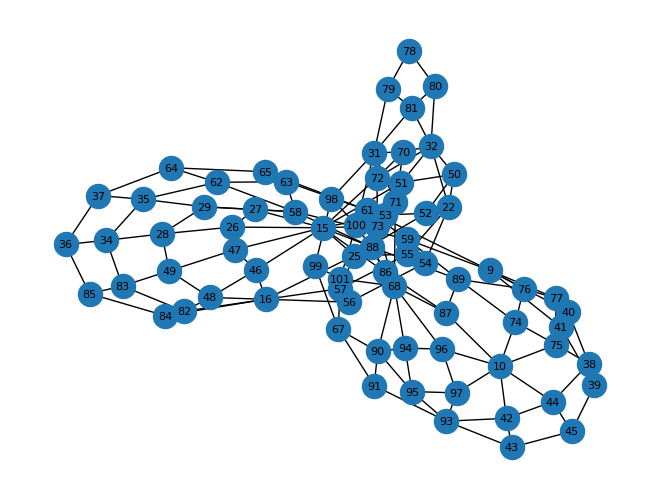

In [360]:
cuadrado = Cuadrado(A)
cuadrado.formar_grafo()
#cuadrado.crear_mazmorra()
nx.draw(cuadrado.S, with_labels=True, font_size = 8)

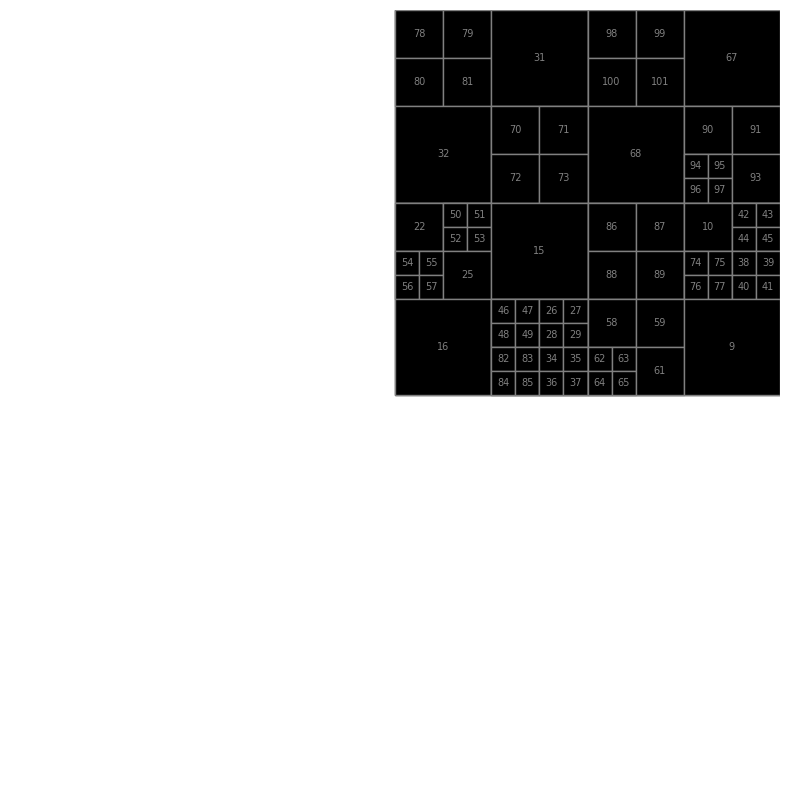

In [361]:
cuadrado.dibujar()

In [404]:
nodos = cuadrado.S.nodes
selec = 10
direcciones = []
# Para cada dirección posible desde el nodo seleccionado...
for attr in nodos[selec]:
    if attr != 'tamaño':
        posible = 0
        # Si en esa dirección el cuadrante contiguo tiene exactamente un tamaño menos...
        for nodo in nodos[selec][attr]:
            if nodos[nodo]['tamaño'] == nodos[selec]['tamaño']-1:
                posible+=1
        # Y hay dos de estos cuadrantes contiguos, es posible expandir en esa dirección
        if posible == 2:
            direcciones.append(attr)
print(f"Posibles: {direcciones}")
if direcciones:
    if 'arriba' in direcciones and 'derecha' in direcciones:
        print("arriba-derecha")
    if 'derecha' in direcciones and 'abajo' in direcciones:
        print("derecha-abajo")
    if 'abajo' in direcciones and 'izquierda' in direcciones:
        print("abajo-izquierda")
    if 'izquierda' in direcciones and 'arriba' in direcciones:
        print("izquierda-arriba")
        
# Encontrar el nodo intermedio de la esquina para conectarlo
# Si existe ese nodo y es de un tamaño menor que el nodo selec, se realiza una unión de tipo 3x3
# Si no existe esa combinación en ninguna dirección posible, se realiza una unión simple dde tipo 3x2

Posibles: ['arriba', 'derecha', 'abajo']
arriba-derecha
derecha-abajo


In [ ]:
'''lista = []
for node in cuadrado.S.nodes:
    if cuadrado.S.nodes[node]['tamaño'] == 0:
        lista.append(node)
        
print(lista)'''
comp = 59

for att in cuadrado.S.nodes[comp]:
    if att != 'tamaño':
        lista = cuadrado.S.nodes[comp][att]
        for nodo in lista:
            if cuadrado.S.nodes[nodo]['tamaño'] == cuadrado.S.nodes[comp]['tamaño']-1:
                print(f"El nodo {comp} tiene al nodo {nodo} {att}")